In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [6]:
import sys
path = "/home/someone/stage_jonathan/lightning-sam/lightning-sam/l_sam_env/lib/python3.10/site-packages"

if path not in sys.path: sys.path.append(path)

path2 = "/usr/lib/python3/dist-packages"

if path2 not in sys.path: sys.path.append(path2)

In [2]:
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

--2023-07-17 16:40:17--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271475 (265K) [image/jpeg]
Saving to: ‘images/truck.jpg’

truck.jpg           100%[===================>] 265,11K  --.-KB/s    in 0,06s   

2023-07-17 16:40:18 (4,28 MB/s) - ‘images/truck.jpg’ saved [271475/271475]

--2023-07-17 16:40:18--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaitin

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import random as rd

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([rd.randint(0,255)/255, rd.randint(0,255)/255, rd.randint(0,255)/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25,zorder=10)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25,zorder=10)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

In [3]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

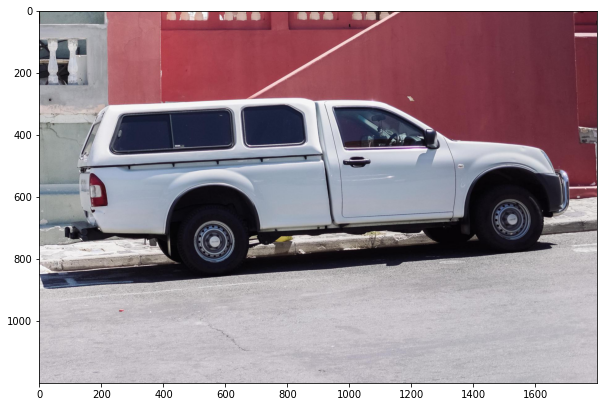

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [9]:
%%time
predictor.set_image(image)

CPU times: user 1.49 s, sys: 54.7 ms, total: 1.54 s
Wall time: 1.54 s


In [10]:
area = image.shape[0] * image.shape[1]

5 iter


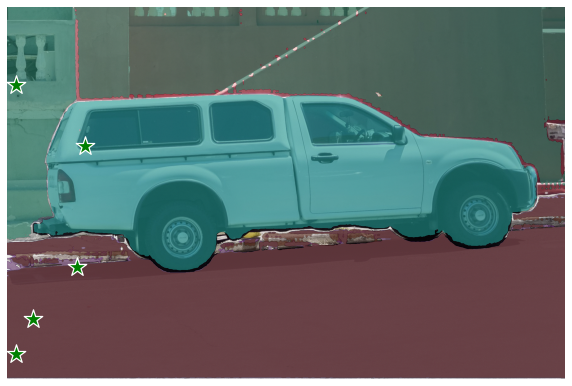

CPU times: user 3.4 s, sys: 918 ms, total: 4.32 s
Wall time: 3.99 s


In [36]:
%%time

import random as rd

curr_area = area

cr = 28 # "compression rate" 

curr_mask = np.zeros((np.array(image.shape)//cr)[:2])

input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)

i = 0
while (curr_mask>1).sum()/np.prod(curr_mask.shape)<0.8:
    
    coords = np.where(curr_mask<1)


    choice = rd.choice(np.array(coords).T)
    
    up = np.array([choice*cr])
    
    masks, scores, logits = predictor.predict(
    point_coords=up,
    point_labels=input_label,
    multimask_output=True,
    )
    
    mask = masks[2]
    show_points(up, input_label, plt.gca())
    show_mask(mask, plt.gca())
    
    
    
    mask_down = cv2.resize((mask*255).astype("uint8"),dsize=(np.array(image.shape)//cr)[:2][::-1],interpolation=cv2.INTER_CUBIC)
    
    curr_mask += mask_down
    
    curr_mask = np.clip(curr_mask,0,255)
    
    #print(up)
    i+=1
    
    
print(i,"iter")
    


plt.axis('off')
plt.show()  
    



In [39]:
(curr_mask>1).sum()/np.prod(curr_mask.shape)

0.9802827380952381

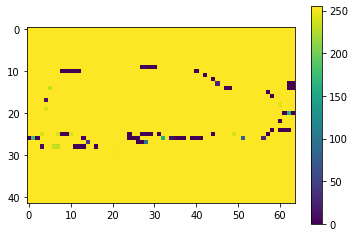

In [37]:
plt.imshow(curr_mask)
plt.colorbar()

## Specifying a specific object with additional points

# Etude des shapes

Etude des shapes à partir 
- d'une dummy image
- d'un batch

(1200, 1800, 3)


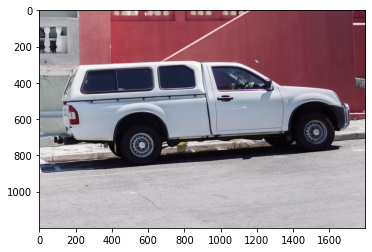

In [14]:
plt.imshow(image)
print(image.shape)
plt.show()

In [15]:
from segment_anything.utils.transforms import ResizeLongestSide

In [16]:
# transform (in set image no torch)

resized = ResizeLongestSide(1024).apply_image(image)


resized.shape

(683, 1024, 3)

In [17]:
tensor = torch.as_tensor(resized).permute(2, 0, 1).unsqueeze(0) # batch
tensor.shape

torch.Size([1, 3, 683, 1024])

In [18]:
# pad (in preprocess)

from torch.nn import functional as F

# registered in the buffer
pixel_mean= torch.Tensor([123.675, 116.28, 103.53]).view(-1, 1, 1)
pixel_std = torch.Tensor([58.395, 57.12, 57.375]).view(-1, 1, 1)

print("mean",pixel_mean.shape)


norm = (tensor -  pixel_mean) / pixel_std
print("norm",norm.shape)


h, w = norm.shape[-2:]
padh = 1024 - h
padw = 1024 - w
padded = F.pad(norm, (0, padw, 0, padh))


mean torch.Size([3, 1, 1])
norm torch.Size([1, 3, 683, 1024])


In [19]:
padded.shape

torch.Size([1, 3, 1024, 1024])

In [20]:
padded = padded.to("cuda")

In [21]:
%%time 
predictor.set_image(image)

CPU times: user 1.05 s, sys: 11.5 ms, total: 1.06 s
Wall time: 1.06 s


In [56]:
predictor.original_size

(1200, 1800)

In [40]:
predictor.features.shape

torch.Size([1, 256, 64, 64])

Padding dégueu

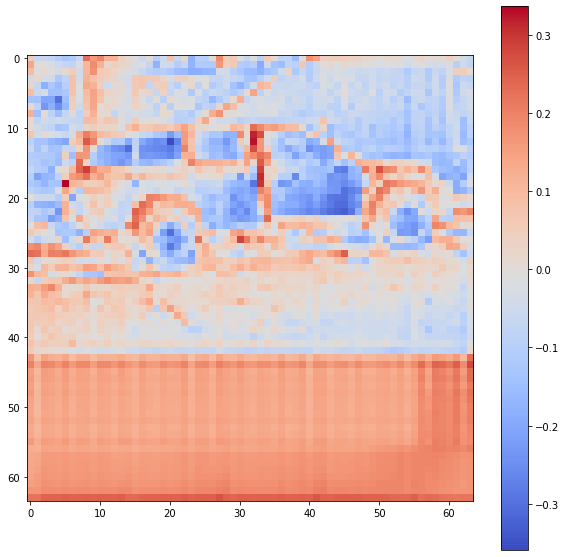

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(predictor.features[0][56].cpu().numpy(),cmap="coolwarm")
plt.colorbar()
plt.show()

In [47]:
input_point = np.array([[500,375]])

input_label = np.array([1])

# possible d'inclure plusieurs points

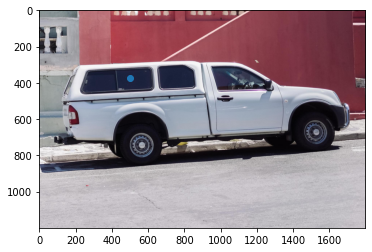

In [55]:
plt.imshow(image)
plt.scatter(input_point[0][0],input_point[0][1])

In [57]:
predictor.transform.apply_coords(input_point,predictor.original_size)

array([[284.44444444, 213.4375    ]])

In [67]:
print(500/1800*1024)

print(375/1800*1024.5) # ! padding + centre pixel ???


284.44444444444446
213.4375
